# Homework 1

## Exercise 1

In [1]:
#Imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

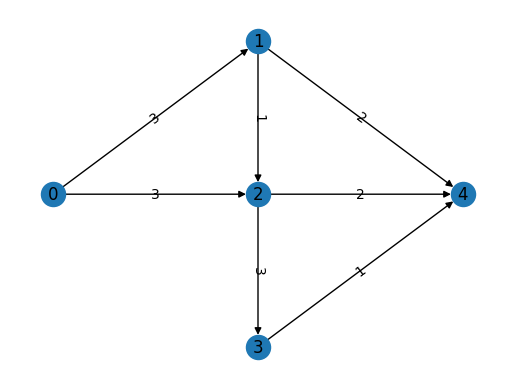

In [2]:
#Define and plot the graph
G = nx.DiGraph()
G.add_edges_from([(0,1,{'capacity':3}),(0,2,{'capacity':3}),(1,2,{'capacity':1}),(2,3,{'capacity':3}),(1,4,{'capacity':2}),(2,4,{'capacity':2}),(3,4,{'capacity':1})])
pos = {0:[-1,1],1:[0,2],2:[0,1],3:[0,0],4:[1,1]}
nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'capacity'))
nx.draw(G,pos,with_labels=True)

### Question 1

In [3]:
def powerset(s):
    p = []
    x = len(s)
    for i in range(1,2**x):
        p.append([s[j] for j in range(x) if (i & (2**j))])
    return p

In [4]:
#Compute the capacity of all the cuts in the graph
def cuts_capa(G):
    nodes = list(G.nodes())
    subsets = powerset(nodes) #Compute all subsets of the set of nodes
    cuts = [s for s in subsets if 0 in s and len(G)-1 not in s] #Compute all cuts in graph (subsets with 0 and without 4)
    adj = nx.adjacency_matrix(G,weight='capacity').toarray()
    caps = []
    for cut in cuts:
        cap = 0
        for n in cut:
            for j in range(1,len(G)):
                if j not in cut:
                    cap += adj[n][j]
        caps.append(cap)
    x = [(cuts[i],caps[i]) for i in range(len(cuts))]
    return sorted(x, key = lambda y: y[1])

cutscapa = cuts_capa(G)
for a,b in cutscapa:
    print('Capacity of cut',a,':',b)

Capacity of cut [0, 1, 2, 3] : 5
Capacity of cut [0] : 6
Capacity of cut [0, 1] : 6
Capacity of cut [0, 2, 3] : 6
Capacity of cut [0, 1, 2] : 7
Capacity of cut [0, 3] : 7
Capacity of cut [0, 1, 3] : 7
Capacity of cut [0, 2] : 8


The maximum flow has throughput equal to the capacity of the minimum cut, in this case 5. The minimum capacity we have to remove from the graph to prevent any flow going from node 0 to node 4 is 5, on the minimum cut, thus the minimum cut would be of capacity 0. In turn the maximum flow would be of throughput 0 which means no flow could go from node 0 to node 4.

### Question 2

We have x units of extra capacity to add to the edges in order to maximize the throughput of the maximum flow in the graph. This means maximizing the capacity of the minimum cut. 
- In order to do that, we need to increase the capacity of the minimum cut to reach the capacity of the cut with the second lowest capacity. 
- Then if we still have extra capacity to add we need to increase the capacity of both of these cuts to reach the capacity of the cut with the third lowest capacity
- Repeat this step until we don't have capacity to allocate

A way to do that is by only allocating the extra capacity 1 at a time then find the new minimum cut and repeat the allocation until we don't have anything to add anymore

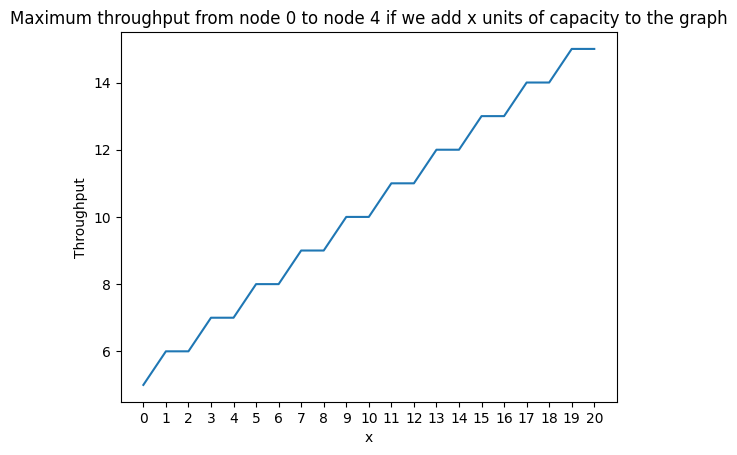

In [5]:
#Returns the max flow if we add x amount of capacity to the edges
def add_cap(G,x):
    G_new = G.copy()
    edges = list(G_new.edges())
    for _ in range(x):
        cutscapa = cuts_capa(G_new)
        cut = cutscapa[0][0]#Get min-cut
        tuc = [i for i in range(len(G_new)) if i not in cut]
        cut_edges = [(x,y) for x in cut for y in tuc] #pairs of nodes, first from the cut, second from outside
        aug = (0,1)
        for e in cut_edges: #Find an edge that is in the cut
            if e in edges:
                aug = e
                break
        G_new[aug[0]][aug[1]]['capacity'] += 1 #add 1 capacity to an edge of the minimum cut

    new_flow = cuts_capa(G_new)[0][1] #Get the new minimum cut=maximum flow throughput
    return new_flow
        


x = np.arange(21)
y = [add_cap(G,i) for i in x]
plt.plot(x,y)
plt.title('Maximum throughput from node 0 to node 4 if we add x units of capacity to the graph')
plt.xticks(x)
plt.xlabel('x')
plt.ylabel('Throughput')
plt.show()

### Question 3

We now dispose of a link of capacity 1 as well as the x units of extra capacity of the previous question. The method to maximize the throughput remains the same but we first need to add our new link to the graph. What we want to do is to increase the capacity of the minimum cut so, if possible, we want to add this link to the minimum cut. In our example this is possible, if it wasn't we should add it to the cut with the lowest capcity to which we could add a link. Then we apply the method of the previous question to increase the throughput.

Capacity of cut [0, 1, 2, 3] : 6
Capacity of cut [0] : 7
Capacity of cut [0, 1] : 7
Capacity of cut [0, 2, 3] : 7
Capacity of cut [0, 1, 2] : 8
Capacity of cut [0, 3] : 8
Capacity of cut [0, 1, 3] : 8
Capacity of cut [0, 2] : 9

Our new graph looks like this:


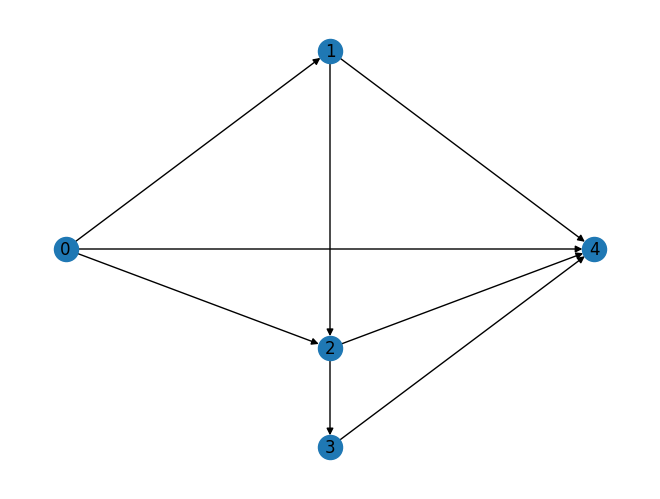

In [6]:
#Look for a place to add a link in the graph to maximize the flow throughput
def add_link(G):
    G_new = G.copy()
    nodes = list(G_new.nodes())
    edges = list(G_new.edges())
    cutcapa = cuts_capa(G_new)
    cuts = [x[0] for x in cutcapa]
    for i in range(len(cuts)): 
        cut = cuts[i]
        tuc = [i for i in range(len(G_new)) if i not in cut]
        possible_edges = [(x,y) for x in cut for y in tuc] #pairs of nodes, first from the cut, second from outside
        cut_edges = [e for e in possible_edges if e in edges]
        if len(cut_edges) < len(possible_edges): #If the cut doesn't have all its nodes linked to all nodes from the complementary of the cut get a pair of nodes that we can link
            b = False
            u,v = 0,0
            for n in cut:
                neighbors = list(G_new.neighbors(n))
                for m in tuc:
                    if m not in neighbors:
                        u,v = n,m
                        b = True
                        break
                if b:
                    break
            G_new.add_edge(u,v,capacity=1)
            break
    return G_new

G2 = add_link(G)
pos2 = {0:[-1,1],1:[0,2],2:[0,0.5],3:[0,0],4:[1,1]}
nx.draw(G2,pos2,with_labels=True)

cutscapa = cuts_capa(G2)
for a,b in cutscapa:
    print('Capacity of cut',a,':',b)

print()
print('Our new graph looks like this:')    

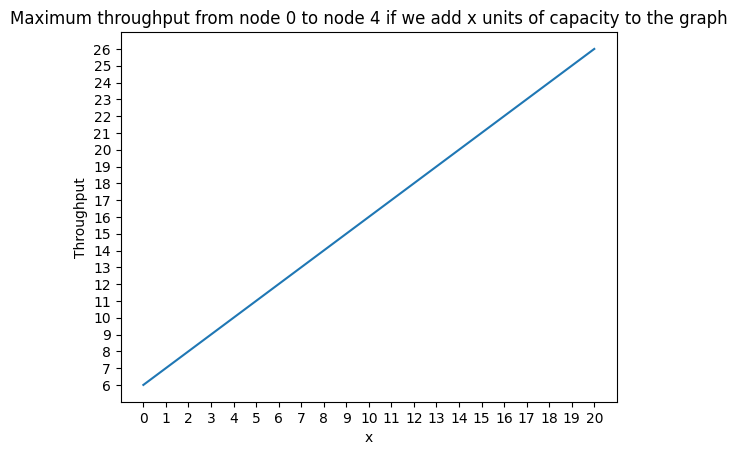

In [7]:
#Plot the results
x = np.arange(21)
y = [add_cap(G2,i) for i in x]
plt.plot(x,y)
plt.title('Maximum throughput from node 0 to node 4 if we add x units of capacity to the graph')
plt.xticks(x)
plt.yticks(np.arange(6,27))
plt.xlabel('x')
plt.ylabel('Throughput')
plt.show()

However, in our case, the link that we add is (0,4) which is present in all cuts because 0 is the source node and 4 is the well node. This means we can simply add a link between 0 and 4 and add all of our capacity to it to maximize the throughput:

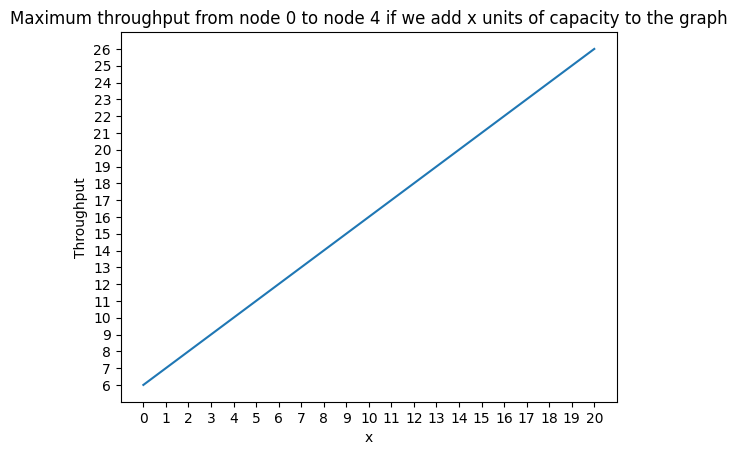

In [8]:
#Another way of doing it
G3 = G.copy()
G3.add_edge(0,4,capacity=1)
y = []
for i in x:
    G3[0][4]['capacity'] = 1+i  
    y.append(nx.maximum_flow_value(G3,0,4))

plt.plot(x,y)
plt.title('Maximum throughput from node 0 to node 4 if we add x units of capacity to the graph')
plt.xticks(x)
plt.yticks(np.arange(6,27))
plt.xlabel('x')
plt.ylabel('Throughput')
plt.show()

## Exercise 2

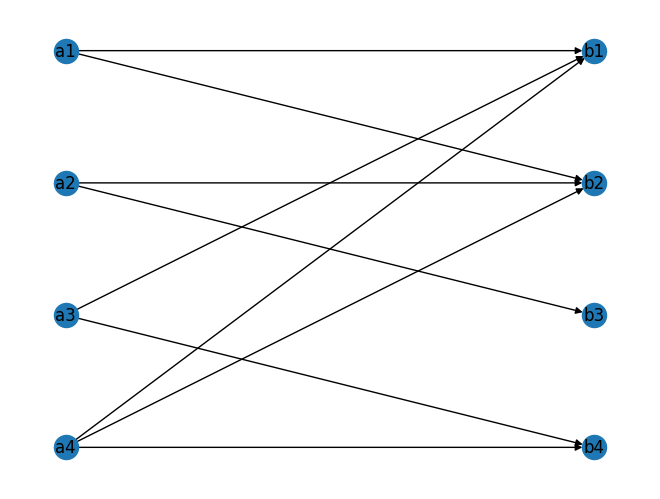

In [9]:
#Define and plot the graph
G = nx.DiGraph()
G.add_edges_from([('a1','b1'),('a1','b2'),('a2','b2'),('a2','b3'),('a3','b1'),('a3','b4'),('a4','b1'),('a4','b2'),('a4','b4'),])
pos = {'a1':[-1,1.5],'a2':[-1,0.5],'a3':[-1,-0.5],'a4':[-1,-1.5],'b1':[1,1.5],'b2':[1,0.5],'b3':[1,-0.5],'b4':[1,-1.5]}

nx.draw(G,pos,with_labels=True)

### Question 1

We want to find a perfect matching in the above graph, if such a matching exits. \
 To do that we are going to add a source node s linked to all nodes $a_i$ and a well node p to which all nodes $b_i$ are linked. Then we are going to set the capacity of all edges in the graph to 1 and compute the maximum flow throughput, if it is equal to 4, the number of nodes in each set, a perfect matching exists and the result of our flow maximization algorithm will give us the matching.

We can now apply the Ford-Fulkerson algorithm to this graph to get our maximum (and hopefully perfet) matching


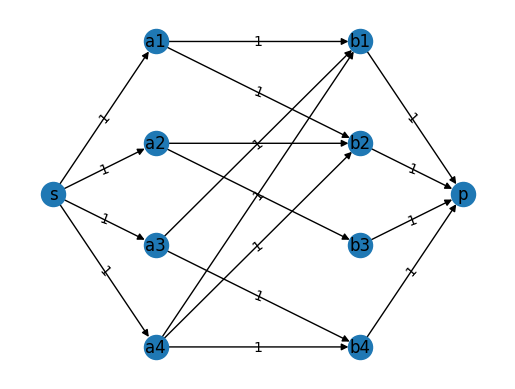

In [10]:
G1 = G.copy()
G1.add_edges_from([('s','a1'),('s','a2'),('s','a3'),('s','a4'),('b1','p'),('b2','p'),('b3','p'),('b4','p')])
pos['s'] = [-2,0]
pos['p'] = [2,0]
for n in list(G1.nodes()):
    for j in G1[n]:
        G1[n][j]['capacity'] = 1
nx.draw_networkx_edge_labels(G1,pos,edge_labels=nx.get_edge_attributes(G1,'capacity'))
nx.draw(G1,pos,with_labels=True)
print("We can now apply the Ford-Fulkerson algorithm to this graph to get our maximum (and hopefully perfet) matching")

The maximum flow has throughput 4
This means a perfect matching exists, the graph with only the edges in the matching is:


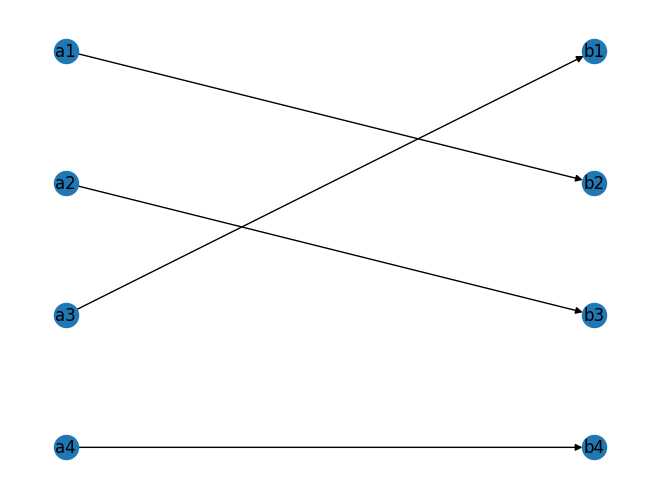

In [11]:
#Apply Ford-Fulkerson and display the matching
m,matching = nx.maximum_flow(G1,'s','p')
Gm = G1.copy()
for n in matching:
    dic = matching[n]
    for k in dic:
        if dic[k] == 0:
            Gm.remove_edge(n,k)
Gm.remove_nodes_from(['s','p'])

print('The maximum flow has throughput',m)
if m == 4:
    print('This means a perfect matching exists, the graph with only the edges in the matching is:')
else:
    print('A perfect matching is impossible, the best matching we can get is:')

nx.draw(Gm,pos,with_labels=True)

### Question 2

Now we dispose of multiple portions of each $b_i$ and each $a_i$ can take an arbitrary number of different food: For example $a_1$ can take 1 portion of $b_1$ and 1 portion of $b_2$ but not 2 portions of $b_1$. To transfer that to our graph we still add the nodes s and p but we have to change the capacities: 
- Since the quantity of each $b_i$ is not 1 anymore we set the capacity on edges ($b_i$,p) to the number of portions of $b_i$
- The $a_i$ can choose different foods but only up to one of each so the capacities between $a_i$ and $b_j$ stay at 1 but the capacities on edges (s,$a_i$) are set to $+\infty$

We can now apply the Ford-Fulkerson algorithm to this graph, the value of the maximum flow will be the number assigned portions of food


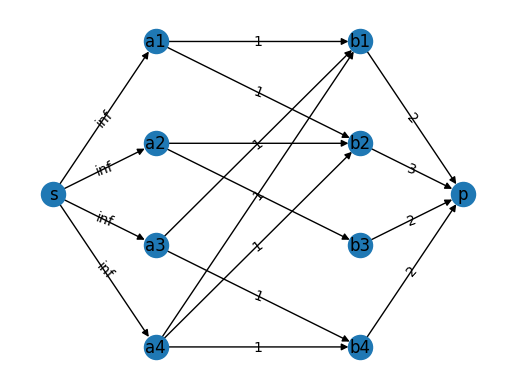

In [12]:
G2 = G.copy()
G2.add_edges_from([('s','a1'),('s','a2'),('s','a3'),('s','a4'),('b1','p'),('b2','p'),('b3','p'),('b4','p')])
portions = [2,3,2,2]

for i in range(1,len(portions)+1):
    G2['b'+str(i)]['p']['capacity'] = portions[i-1]
    G2['s']['a'+str(i)]['capacity'] = float('inf')

for n in list(G.nodes()):
        for j in G[n]:
            G2[n][j]['capacity'] = 1

nx.draw_networkx_edge_labels(G2,pos,edge_labels=nx.get_edge_attributes(G2,'capacity'))
nx.draw(G2,pos,with_labels=True)
print("We can now apply the Ford-Fulkerson algorithm to this graph, the value of the maximum flow will be the number assigned portions of food")

The maximum number of portions of food we can assign is: 8
It is possible if a1 takes 1 portion of b2, a2 takes 1 portion of b2 and 1 portion of b3, a3 takes 1 portion of b1 and 1 portion of b4 and a4 takes 1 portion of b1, 1 portion of b2 and 1 portion of b4.


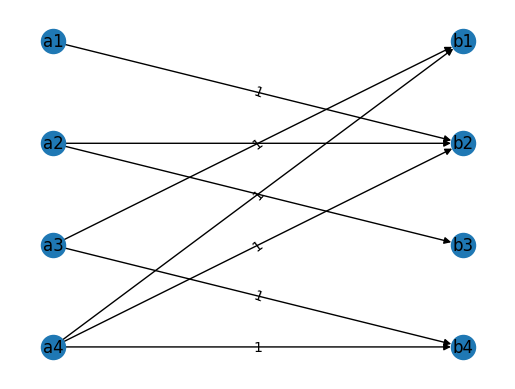

In [13]:
#Show the results
p, matching = nx.maximum_flow(G2,'s','p')
print('The maximum number of portions of food we can assign is:',p)

assoc = {k:matching[k] for k in matching if k[0]=='a'}

def print_assoc(assoc): #Overcomplicated function to display the result in text form
    p = ''
    n = len(assoc)
    for j,a in enumerate(assoc):
        portions = assoc[a]
        l = len(portions)
        if j != 0:
            if j == n-1:
                p += ' and '
            else:
                p += ', '
        first = True
        for i,portion in enumerate(portions):
            q = portions[portion]
            if q > 0:
                if first:
                    p += a+' takes'
                    first = False
                else:
                    if i == l-1:
                        p += ' and'
                    else:
                        p += ','
                p += ' '+str(q)+' portion'
                if q != 1:
                    p += 's'
                p += ' of '+portion
    p +='.'
    return p
        


print('It is possible if',print_assoc(assoc))
#print(assoc)
#Remove unnecessary edges
Gc = G2.copy()
Gc.remove_nodes_from(['s','p'])
labels = {}
for a in assoc:
    dic = assoc[a]
    for b in dic:
        if not dic[b]:
            Gc.remove_edge(a,b)
        else:
            labels[(a,b)] = 1

nx.draw_networkx_edge_labels(Gc,pos,edge_labels=labels)
nx.draw(Gc,pos,with_labels=True)


### Question 3

Now each person wants a certain quantity of food and is allowed to take multiple portions of the same food.\
We still add nodes s and p to the graph with the capacities following these new rules:
- We set the capacity on edges ($b_i$,p) to the number of portions of $b_i$
- We set the capacity on edges (s,$a_i$) to the number of portions $a_i$ wants
- The edges between $a_i$ and $b_j$ have capacity +$\infty$ since people can now take as many portions of one food as they want

We can now apply the Ford-Fulkerson algorithm to this graph, the value of the maximum flow will be the number assigned portions of food


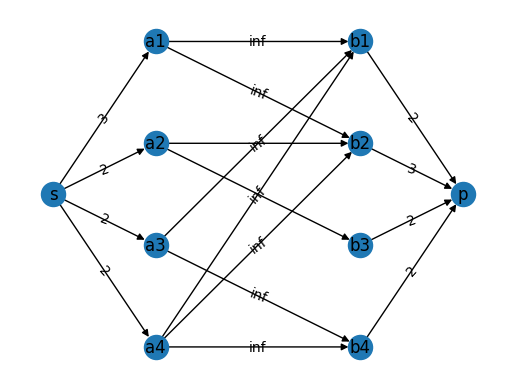

In [14]:
G3 = G.copy()
G3.add_edges_from([('s','a1'),('s','a2'),('s','a3'),('s','a4'),('b1','p'),('b2','p'),('b3','p'),('b4','p')])
portions = [2,3,2,2]
want = [3,2,2,2]

for i in range(1,len(portions)+1):
    G3['b'+str(i)]['p']['capacity'] = portions[i-1]
    G3['s']['a'+str(i)]['capacity'] = want[i-1]

for n in list(G.nodes()):
        for j in G[n]:
            G3[n][j]['capacity'] = float('inf')

nx.draw_networkx_edge_labels(G3,pos,edge_labels=nx.get_edge_attributes(G3,'capacity'))
nx.draw(G3,pos,with_labels=True)
print("We can now apply the Ford-Fulkerson algorithm to this graph, the value of the maximum flow will be the number assigned portions of food")

The maximum number of portions of food we can assign is: 9
It is possible if a1 takes 3 portions of b2, a2 takes 2 portions of b3, a3 takes 2 portions of b1 and a4 takes 2 portions of b4.


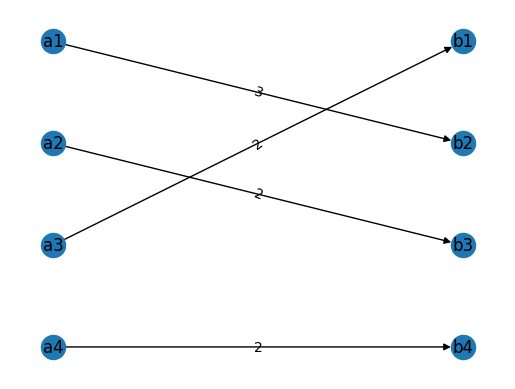

In [15]:
p, matching = nx.maximum_flow(G3,'s','p')
print('The maximum number of portions of food we can assign is:',p)

assoc = {k:matching[k] for k in matching if k[0]=='a'}
#print(assoc)

print('It is possible if',print_assoc(assoc))


#Remove unnecessary edges
Gc = G3.copy()
Gc.remove_nodes_from(['s','p'])
labels = {}
for a in assoc:
    dic = assoc[a]
    for b in dic:
        val = dic[b]
        if not val:
            Gc.remove_edge(a,b)
        else:
            labels[(a,b)] = val 

nx.draw_networkx_edge_labels(Gc,pos,edge_labels=labels)
nx.draw(Gc,pos,with_labels=True)

## Exercise 3

In [16]:
#Imports
from scipy.io import loadmat
import cvxpy as cp

In [17]:
#Load data

B = loadmat('traffic.mat')['traffic']
#print(B.shape)
#print(B)
C = loadmat('capacities.mat')['capacities']
#print(C)
#print(C.shape)
l = loadmat('traveltime.mat')['traveltime']
#print(l)
#print(l.shape)
F = loadmat('flow.mat')['flow']
#print(f)
#print(f.shape)

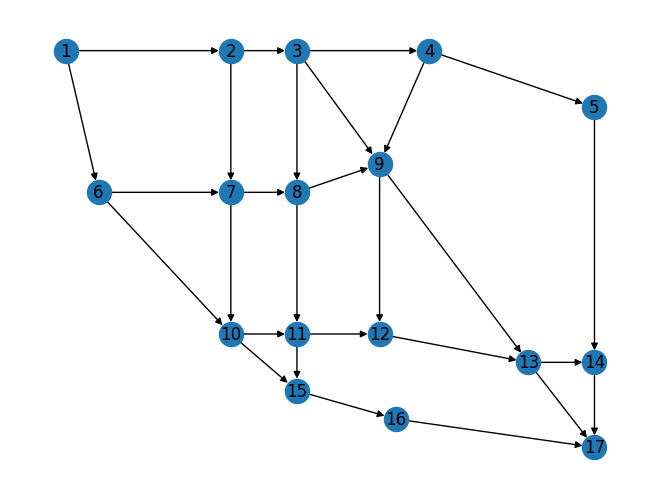

In [18]:
#Create the graph from B

G = nx.DiGraph()
edges = []
m,n = B.shape
for e in range(n):
    u,v = 0,0
    for i in range(m):
        if B[i][e] == 1:
            u = i
        elif B[i][e] == -1:
            v = i
    edges.append((u+1,v+1))

G.add_edges_from(edges)
pos = {1:[0,0],2:[5,0],3:[7,0],4:[11,0],5:[16,-2],6:[1,-5],7:[5,-5],8:[7,-5],9:[9.5,-4],10:[5,-10],11:[7,-10],12:[9.5,-10],13:[14,-11],14:[16,-11],15:[7,-12],16:[10,-13],17:[16,-14]}
nx.draw(G,pos,with_labels=True)

### Question 1

In [ ]:
#Find shortest path
n_nodes,n_edges = B.shape
l = l.reshape(-1)

nu = np.eye(1,n_nodes,0)-np.eye(1,n_nodes,n_nodes-1)
nu = nu.reshape(-1)

f = cp.Variable(n_edges)
obj = cp.Minimize(l.T@f)
constraints = [B@f == nu, f>=0]
problem = cp.Problem(obj,constraints)

result = problem.solve()
print(f.value)
print(np.round(f.value))

[9.99999968e-01 9.99999967e-01 5.55518047e-10 2.36996643e-10
 3.22247775e-08 1.89730210e-08 1.16121182e-08 4.15115397e-09
 9.99999868e-01 4.23081043e-10 6.71622692e-10 9.99999966e-01
 3.18521393e-10 2.36996337e-10 1.32517570e-08 3.21976961e-09
 1.78159719e-08 7.78398418e-09 8.13258700e-09 1.02324548e-07
 1.04404208e-08 1.12764968e-07 2.06221906e-09 9.11935795e-10
 9.99999979e-01 2.29921479e-09 1.87279076e-08 1.87279071e-08]
[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]


In [20]:
k = np.where(f.value>0.5)[0]
#print(k)
#print(edges)
path = [edges[i] for i in k]
path = sorted(path,key= lambda x:x[0])

print('Shortest path:',path)

Shortest path: [(1, 2), (2, 3), (3, 9), (9, 13), (13, 17)]


### Question 2

The maximum flow from node 1 to node 17 is: 22448
We can obtain it by performing the following flow allocations:
Red values are capacities and blue ones are flows


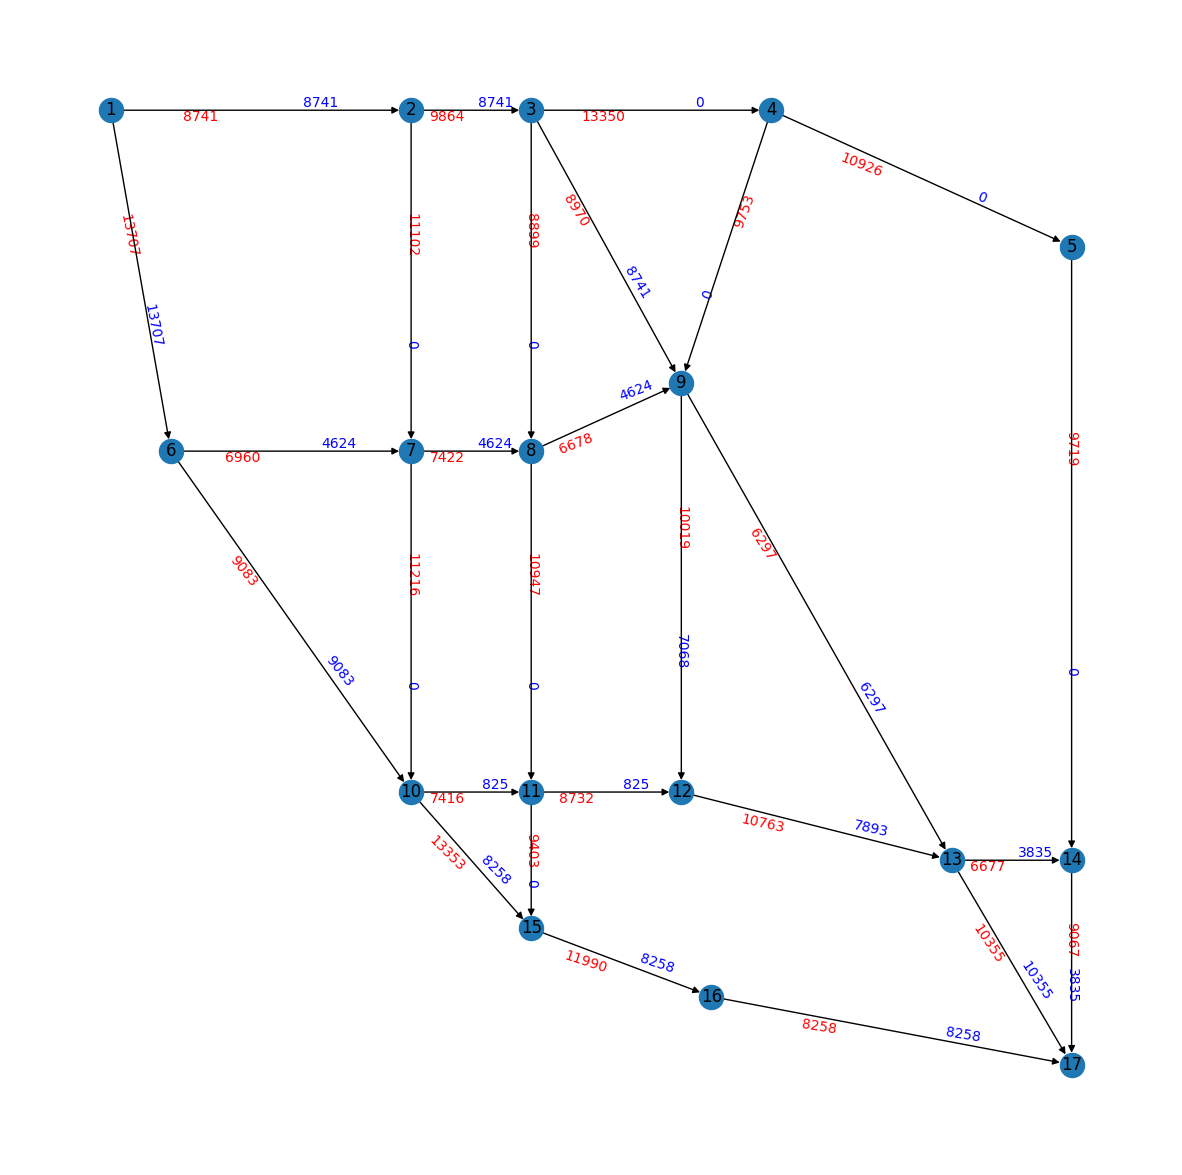

In [ ]:
#Find maximum flow

C = C.reshape(-1)
#print(edges)
cap_edges = []
for i in range(len(edges)):
    a,b = edges[i]
    x = (a,b,{'capacity':C[i]})
    cap_edges.append(x)
#print(cap_edges)

G2 = nx.DiGraph()
G2.add_edges_from(cap_edges)
value,alloc = nx.maximum_flow(G2,1,17)
print('The maximum flow from node 1 to node 17 is:',value)
print('We can obtain it by performing the following flow allocations:')

clabels = {edges[i]:C[i] for i in range(28)}
flabels = {}
for i in alloc:
    neigh = alloc[i]
    for j in neigh:
        flabels[(i,j)] = neigh[j]


print('Red values are capacities and blue ones are flows')
fig,ax = plt.subplots(figsize=(15,15))
nx.draw_networkx_edge_labels(G2,pos,flabels,font_color='blue',verticalalignment='bottom',ax=ax,label_pos=0.3)
nx.draw_networkx_edge_labels(G2,pos,clabels,font_color='red',verticalalignment='top',ax=ax,label_pos=0.7)
nx.draw(G2,pos,with_labels=True,ax=ax)

### Question 3

In [22]:
F = F.reshape(-1)
nu = B@F
print('The exogenous flow vector associated with the flow stored in flow.mat is')
print(nu.reshape(-1))

The exogenous flow vector associated with the flow stored in flow.mat is
[ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


### Question 4

In [23]:
nu0 = nu[0]
nu = nu0*(np.eye(1,17,0)-np.eye(1,17,16)).reshape(-1)
print(nu)

[ 16282.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0. -16282.]


In [ ]:
#Compute social optimum
from scipy.optimize import minimize

def obj(f):
    return np.sum(l*C/(1-f/C)-l*C)

const = [{'type': 'ineq','fun': lambda f: f},{'type': 'ineq','fun': lambda f: C-f},{'type': 'eq','fun': lambda f: B@f-nu}]
res = minimize(obj,np.zeros(n_edges),constraints=const,method='SLSQP')

print('The social optimum cost is:',res.fun)
fe = res.x
print('It is reachable with the following flow vector:',fe.astype(int))

The social optimum cost is: 47544.1512158902
It is reachable with the following flow vector: [8292 6419  597  597 7989 3817 3221 1341 5032 1872    0 5822    0  597
 4171 2755 3885 2469 1880 2130 2653 4784 2680 1982 7136 3278 5867 5867]


### Question 5

In [ ]:
#Compute Wardrop equilibirum
def wardrop_obj(f):
    return np.sum(-l*C*np.log(1-f/C))

const = [{'type': 'ineq','fun': lambda f: f},{'type': 'ineq','fun': lambda f: C-f},{'type': 'eq','fun': lambda f: B@f-nu}]
res = minimize(wardrop_obj,np.zeros(n_edges),constraints=const,method='SLSQP')

print('The Wardrop cost is:',obj(res.x))
print('The Wardrop equilibirum is:',res.x.astype(int))

The Wardrop cost is: 93960.04007167573
The Wardrop equilibirum is: [8551 8096    0    0 7730 5385 2699   38 4400  455    0 8096    0    0
 2344 2580 2905 3141 2660 3735 2423 6158 2372 2817 8186 2372 5723 5723]


C:\Users\maelm\AppData\Local\Temp\ipykernel_48680\1333062151.py:2: RuntimeWarning: invalid value encountered in log
  return np.sum(-l*C*np.log(1-f/C))


### Question 6

In [ ]:
#Compute Wardrop equilibrium with tolls
def obj_tol(f):
    return np.sum(-l*C*np.log(1-f/C)+f*fe*l/(C*(1-fe/C)**2)) #We added tolls

const = [{'type': 'ineq','fun': lambda f: f},{'type': 'ineq','fun': lambda f: C-f},{'type': 'eq','fun': lambda f: B@f-nu}]
res = minimize(obj_tol,np.zeros(n_edges),constraints=const,method='SLSQP')


print('The new Wardrop equilibirum is:',res.x.astype(int))

The new Wardrop equilibirum is: [8310 6424 1046  818 7971 3705 3204 1541 5000 1886  151 5226  227  818
 4265 2738 3914 2387 1814 1995 2639 4635 2600 1913 7035 3418 5827 5827]


In [39]:
a = res.x
print('Price of anarchy:',obj(a)/obj(fe))

Price of anarchy: 1.0124431065207784


Since the price of anarchy is very close to 1, the wardrop cost and the social optimum cost are equal: The Wardrop equilibrium is equal to the social optimum.

### Question 7

In [26]:
#Social optimum
def new_obj(f):
    return np.sum(l*f**2/(C-f))

const = [{'type': 'ineq','fun': lambda f: f},{'type': 'ineq','fun': lambda f: C-f},{'type': 'eq','fun': lambda f: B@f-nu}]
res = minimize(new_obj,np.zeros(n_edges),constraints=const,method='SLSQP')

print('Our new social optimum cost is:',res.fun)
new_fe = res.x
print('The system optimum is:',new_fe.astype(int))

Our new social optimum cost is: 36942.10939128722
The system optimum is: [8258 6525  148  144 8023 3984 3147 1113 5144 1733    0 6375    4  144
 4038 2759 3849 2570 2035 2348 2690 5039 2880 2104 7303 3024 5954 5954]


In [27]:
#Wardrop
def new_wardrop_obj(f):
    return np.sum(-l*C*np.log(1-f/C)-l*f)

const = [{'type': 'ineq','fun': lambda f: f},{'type': 'ineq','fun': lambda f: C-f},{'type': 'eq','fun': lambda f: B@f-nu}]
res = minimize(new_wardrop_obj,np.zeros(n_edges),constraints=const,method='SLSQP')

print('The new Wardrop cost is:',new_obj(res.x))
print('The new Wardrop equilibrium is:',res.x.astype(int))

The new Wardrop cost is: 38885.062196760555
The new Wardrop equilibrium is: [8314 6430  615  598 7967 3803 3216 1345 5036 1883   11 5804   16  598
 4164 2751 3883 2470 1882 2129 2651 4780 2681 1982 7135 3280 5865 5865]


In [ ]:
#Tolls
def new_obj_tol(f):
    return np.sum(-l*C*np.log(1-f/C)-l*f+f*new_fe*l/(C*(1-new_fe/C)**2))

const = [{'type': 'ineq','fun': lambda f: f},{'type': 'ineq','fun': lambda f: C-f},{'type': 'eq','fun': lambda f: B@f-nu}]
res = minimize(new_obj_tol,np.zeros(n_edges),constraints=const,method='SLSQP')

print('The new Wardrop equilibrium is:',res.x.astype(int))

The new Wardrop equilibrium is: [ 8735  8725    29    12  7546  6948  3184    24   591     9    10  8685
    17    12   598  3745   626  3773  3170  8135  2008 10144   394  4906
 10341   406  5533  5533]


C:\Users\maelm\AppData\Local\Temp\ipykernel_6240\2529839016.py:2: RuntimeWarning: invalid value encountered in log
  return np.sum(-l*C*np.log(1-f/C)-l*f+f*new_fe*l/(C*(1-new_fe/C)**2))


In [29]:
a = res.x
print('Price of anarchy:',new_obj(a)/new_obj(new_fe))

Price of anarchy: 93.66881031000767


In [30]:
print(np.linalg.norm(new_fe-a)/np.linalg.norm(new_fe))

0.5636153250592575
